<center><h1 style="color:red;"> MacDonald France E-reputation </h1></center>

<center><h2>Opinion Mining</h2></center>

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import Counter,defaultdict

import spacy

from pyLDAvis.gensim import prepare
from pyLDAvis import display

import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

import nltk 
from wordcloud import WordCloud

from textblob_fr import PatternTagger, PatternAnalyzer
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import keras
from keras.callbacks import EarlyStopping

from ipyleaflet import Map, Marker

import stylecloud
from IPython.display import Image

nlp = spacy.load('fr_core_news_sm')

<h1> Functions To Use: </h1>

In [3]:
stem = SnowballStemmer('french')

sp =stopwords.words('french')
sp_steam = ['tres','plus','trop','do','mac','mc','mcdo','macdo','mcdonald','donald', 'moin','tous','auss','san','peu','tout','ça']

def tokenize_text(text):
    return simple_preprocess(text)

def stemm_text (text):
    return stem.stem(text)
    
def lemma_text(vec):
    tmp_text=  " ".join(vec)
    return [x.lemma_ for x in nlp(tmp_text)]
    
def process(text, lemma=False, sp_words=False):
    results = []
    for word in tokenize_text(text.lower()):
        if word not in sp and len(word) >3 : 
            if sp_words==True:
                if stemm_text(word) not in sp_steam:
                    results.append(word)
            else :
                results.append(word)
    if lemma == True:
        return lemma_text(results)
    return list(map(lambda x: stemm_text(x), results))


def process_tweet(text):
    results = []
    for word in tokenize_text(text.lower()):
        if word not in sp and len(word) >3 : 
            results.append(stemm_text(word))
    return list(results)


def create_wordcloud(data, lemma = False, sp_words=False,max_font_size=30, scale = 3 ,background_color="white", figsize=(15,15)):
    full_corpus = " ".join(data.review.values)

    counter = Counter(process(full_corpus, lemma,sp_words))

    wc = WordCloud(max_font_size=max_font_size, scale = scale ,background_color=background_color)
    cloud = wc.generate_from_frequencies(counter)
    fig = plt.figure(1, figsize=figsize)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
        
    return counter, plt

def create_wordcloud_plot(data, plt,lemma = False, sp_words=False,max_font_size=30, scale = 3 ,background_color="white"):
    full_corpus = " ".join(data.review.values)

    counter = Counter(process(full_corpus, lemma,sp_words))

    wc = WordCloud(max_font_size=max_font_size, scale = scale ,background_color=background_color)
    cloud = wc.generate_from_frequencies(counter)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
        
    return counter, plt

 
def create_dictionnaire(data, lemma = False, sp_words=False):
    texts = data.review.apply(lambda x: process(x, lemma, sp_words))
    dictionnaire = Dictionary(texts)
    return dictionnaire, texts
    
def create_model (dictionnaire , texts):    
    dictionnaire.filter_extremes(5,0.5)
    bag_words = texts.apply(lambda x: dictionnaire.doc2bow(x))
    tfidf = TfidfModel(bag_words.values.tolist(),id2word=dictionnaire)
    tfds_corpus = [tfidf[e] for e in bag_words]
    return tfds_corpus, bag_words
    

<h2><span style="color: green;">1 : Etape Collecter les données / Data Collection</span><h2>

In [4]:
mcdonald = pd.read_csv('googleAll.csv')
burgerking = pd.read_csv('burgerkink_reviewsF.csv')
zinc = pd.read_csv('zinc_reviewsF.csv')

mcdonald.date = pd.to_datetime(mcdonald.date)
burgerking.date = pd.to_datetime(burgerking.date)
zinc.date = pd.to_datetime(zinc.date)

In [6]:
mcdonald.head(1)

,review,rating,date,loc
0,"Musique à fonds dans le fast-food, on ne s’ent...",2,2019-04-22,"Centre commercial Coty, Avenue René Coty, 7660..."


<span style="color: blue;">Les concurrents par rapport à Macdonald: Zinc et bugerking</span>

In [7]:
burgerking.head(1)

,review,rating,date
0,C'est un bon burger King il n'y a rien à dire ...,4,2020-03-26


In [8]:
zinc.head(1)

,review,rating,date
0,Trop peu de choix dans le menu ( 1 seul poisso...,3,2020-03-26


<h2><span style="color: green;">2 :Analyse de l'opinion: descriptive / Opinion Analyst: Descriptive Statistics  </span><h2>

<h3> <span style="color: blue;">Les avis du Macdonald  par rapport au rating </span></h3>

- En premier lieu , on a comparé les differents opinions de Mac Do France en  le comparant avec ses concurents directs Burger King et Zinc en se basant sur les Ratings seulement.


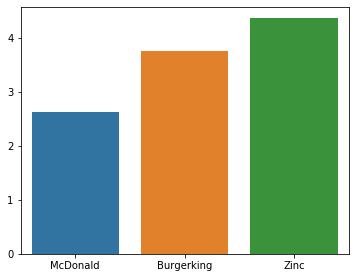

In [9]:
mcdonald_rating_mean = mcdonald.rating.mean()
burgerking_rating_mean = burgerking.rating.mean()
zinc_rating_mean = zinc.rating.mean()
mcdonald_rating_count = mcdonald.groupby('rating').count()
burgerking_rating_count = burgerking.groupby('rating').count()
zinc_rating_count = zinc.groupby('rating').count()
plt.figure(figsize=(20,10))
plot0 = plt.subplot(2,3,2)
sns.barplot(['McDonald','Burgerking','Zinc'],[mcdonald_rating_mean, burgerking_rating_mean, zinc_rating_mean], ax=plot0);

<h3> <span style="color: blue;">les avis du macdonald & Zinc & Burger King par rapport au rating </span></h3>

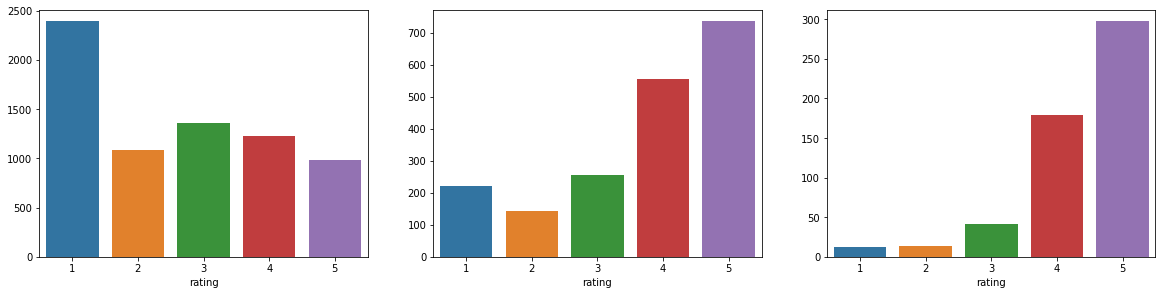

In [10]:
plt.figure(figsize=(20,10))
plot1 = plt.subplot(2,3,4)
plot2 = plt.subplot(2,3,5)
plot3 = plt.subplot(2,3,6)
sns.barplot(mcdonald_rating_count.index, mcdonald_rating_count.review.values.ravel(), ax= plot1);
sns.barplot(burgerking_rating_count.index, burgerking_rating_count.review.values.ravel(), ax= plot2);
sns.barplot(zinc_rating_count.index, zinc_rating_count.review.values.ravel(), ax= plot3);

- D'aprés ces stastiques , on peut remarquer que le rating moyenne de Mac Do est 2.5 , Burger King est 3.5 et Zinc est 4.3 
- Si on analyse chaque marque , on remarque que les ratings négatives sont de forte présence dans Mac Do par rapport à une faible présence chez ses concurents
- Donc , on peut interpréter qu'il y a  des points faibles négatives chez Mac Do tel qu'on va les interpréter et par conséquent une e-réputation négative sur les réseaux sociaux.

<h3> <span style="color: blue;">les avis du macdonald & Zinc & Burger King par rapport au temps </span></h3>

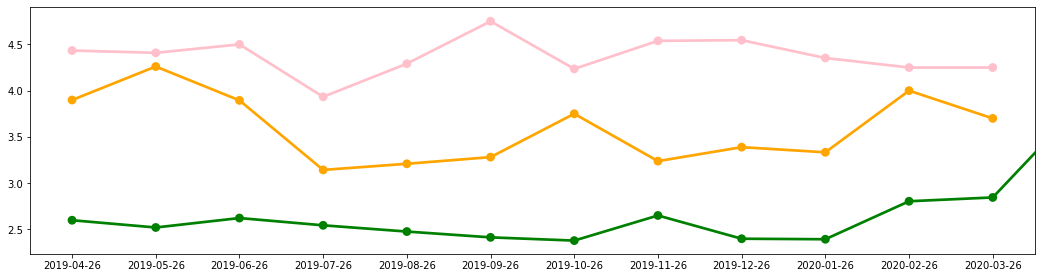

In [11]:
current_year_val = mcdonald[mcdonald.date.dt.year>=2019].groupby('date').mean()
current_year_val_burger = burgerking[burgerking.date.dt.year>=2019].groupby('date').mean()
current_year_val_zinc = zinc[zinc.date.dt.year>=2019].groupby('date').mean()

years_val = mcdonald.groupby(mcdonald.date.dt.year).mean()
#years_val_burger = burgerking.groupby(burgerking.date.dt.year).mean()
#years_val_zinc = zinc.groupby(zinc.date.dt.year).mean()


plt.figure(figsize=(18,10))
plot1 = plt.subplot(2,1,1)
sns.pointplot(current_year_val.index.format(), current_year_val.values.ravel(), color="green" ,ax= plot1);
sns.pointplot(current_year_val_burger.index.format(), current_year_val_burger.values.ravel(), color="orange" ,ax= plot1);
sns.pointplot(current_year_val_zinc.index.format(), current_year_val_zinc.values.ravel(), color="pink" ,ax= plot1);

#sns.pointplot(years_val_burger.index, years_val_burger.values.ravel(), ax= plot2)
#sns.pointplot(years_val_zinc.index, years_val_zinc.values.ravel(), ax= plot2)

<h3> <span style="color: blue;">les avis du macdonald par année</span></h3>

- En second lieu , on a comparé les differents opinions de Mac Do France en  le comparant avec ses concurents directs Burger King et Zinc en basant sur les Ratings par rapport à l'axe temps. En effet , on a comparé les ratings à partir du mois Avril 2019 jusqu'à Mars 2020.
- De plus , on a représenté l'évolution des ratings en fonction des années de 2012 jusqu'à 2020.


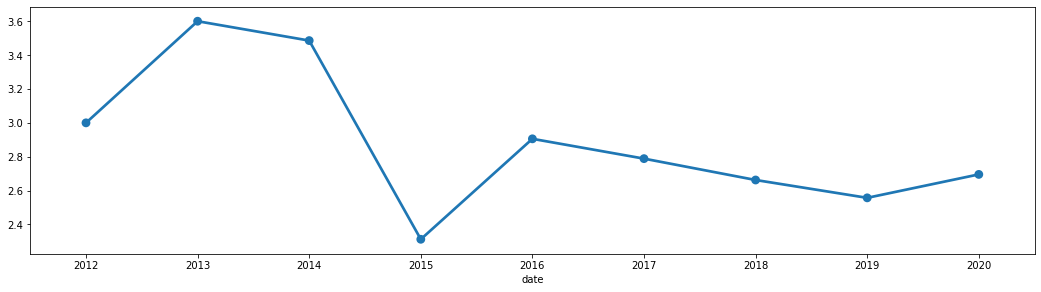

In [12]:
plt.figure(figsize=(18,10))
plot2 = plt.subplot(2,1,2)
sns.pointplot(years_val.index, years_val.values.ravel(), ax= plot2);

- En comparant les ratings de Mac Do par rapport à ses concurents en focnction du temps , on remarque qu'il est stable entre Avril 2019 et Mars 2020 mais il est moyen , environ 3. Par contre ses concurents ne sont  pas assez stables mais ils ont des ratings forts.
- La 2éme  courbe montre que Mac Do a eu une évolution entre 2012 et 2013 mais une chute brusque entre 2014 et 2015 et enfin une stabilté à paritr de 2016.

<h3> <span style="color: blue;">les avis du macdonald par localisation</span></h3>

0 : 140 Av. des Champs-Élysées, 75008 Paris, France
1 : 17, Avenue Pierre Mendès-France, Rue du Tribunal, 67300 Schiltigheim, France
2 : 37 Avenue Georges Clemenceau, 93420 Villepinte, France
3 : 450 Traverse d'Orange, 84110 Saint-Romain-en-Viennois, France
4 : Centre Commercial Auchan, Rue Anatole France, 59494 Petite-Forêt, France
5 : Centre Commercial les 3 Fontaines, Avenue Pierre Mendès France, 45140 Saint-Jean-de-la-Ruelle, France
6 : Centre commercial Coty, Avenue René Coty, 76600 Le Havre, France
7 : Espace Mendes France, Avenue de Paris, 79000 Niort, France
8 : Gare SNCF Chateaucreux, 2 Espl. de France, 42000 Saint-Étienne, France
9 : Lieu dit Aux Poses Shopping, 74100 Etrembières, France
10 : ZAC dit du Parc et du Centre Touristique Lieu dit Disney Village Coupvray FR, 77700 Chessy, France
11 : ZAC du Cornillon Sud, 1 Rue des Trémies, 93200 Saint-Denis, France




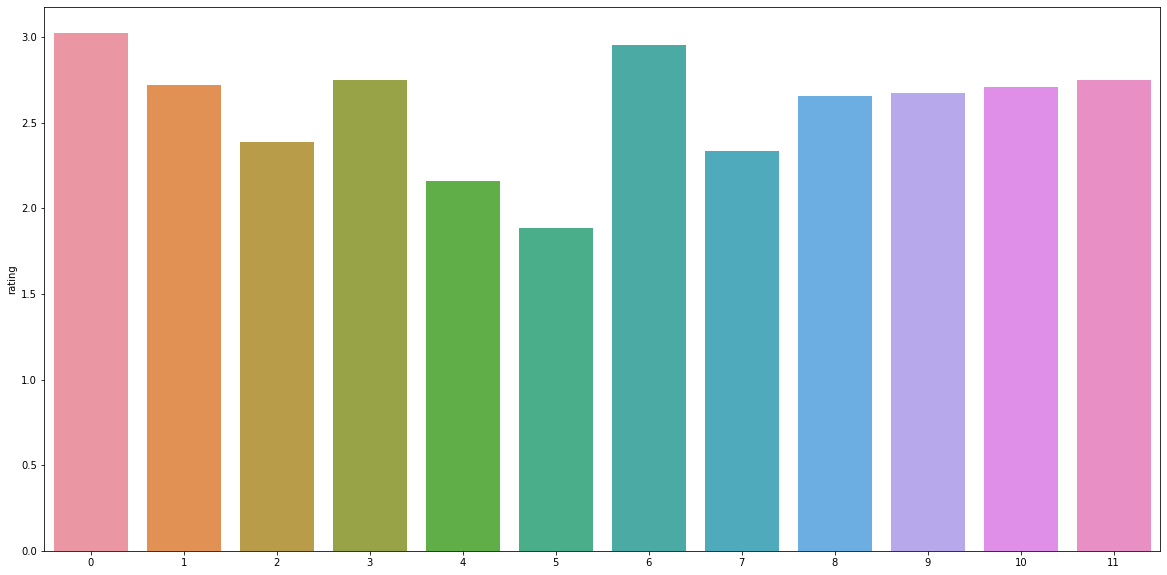

In [13]:
mcdonald_loc_rating = mcdonald.groupby('loc').mean()
loc_num = dict(enumerate(mcdonald_loc_rating.index))
plt.figure(figsize=(20,10))
sns.barplot(list(loc_num.keys()), mcdonald_loc_rating.rating);
for i,v in loc_num.items():
    print("%d : %s"%(i,v))
print("\n")    

In [14]:
places = {
    "Centre commercial Coty, Avenue René Coty, 76600 Le Havre, France":(49.495852, 0.111733),
    "450 Traverse d'Orange, 84110 Saint-Romain-en-Viennois, France": (44.255665, 5.096491),
    "Espace Mendes France, Avenue de Paris, 79000 Niort, France":(46.338296, -0.414743) ,
    "Gare SNCF Chateaucreux, 2 Espl. de France, 42000 Saint-Étienne, France": (45.443434, 4.399102),
    "450 Traverse d'Orange, 84110 Saint-Romain-en-Viennois, France": (44.255634, 5.096427),
    "Lieu dit Aux Poses Shopping, 74100 Etrembières, France":(46.181754, 6.230830),
    "Centre Commercial les 3 Fontaines, Avenue Pierre Mendès France, 45140 Saint-Jean-de-la-Ruelle, France": (47.905050, 1.864457) ,
    "17, Avenue Pierre Mendès-France, Rue du Tribunal, 67300 Schiltigheim, France":(48.602738, 7.755919),
    "Centre commercial Coty, Avenue René Coty, 76600 Le Havre, France" : (49.495949, 0.110502),
    "Centre Commercial Auchan, Rue Anatole France, 59494 Petite-Forêt, France":(50.374367, 3.482948),
    "140 Av. des Champs-Élysées, 75008 Paris, France":(48.873132, 2.298872),
    "ZAC dit du Parc et du Centre Touristique Lieu dit Disney Village Coupvray FR, 77700 Chessy, France":(48.868081, 2.785233),
    "ZAC du Cornillon Sud, 1 Rue des Trémies, 93200 Saint-Denis, France":(48.921558, 2.362809),
    "37 Avenue Georges Clemenceau, 93420 Villepinte, France":(48.953932, 2.563590),
}

m = Map(center=(47.421479, 2.632441), zoom=5)
print("***********************************************")
print("HOVER OVER THE MARKERS TO SHOW AVERAGE RATINGS ")
print("***********************************************")
for item, value in zip(mcdonald_loc_rating.index,mcdonald_loc_rating.values):
    marker = Marker(location=places[item], draggable=True, title= str(value))
    m.add_layer(marker);
m

***********************************************
HOVER OVER THE MARKERS TO SHOW AVERAGE RATINGS 
***********************************************


Map(center=[47.421479, 2.632441], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

- En comparant les  différents locaux de Mac Do France , on trouve que les ratings sont équilibrés entre eux avec la présence de quelques exceptions. Donc , il y a des locaux qui sont plus positifs tels que "Avenue Pierre Mendès-France, Rue du Tribunal" et celle de "Centre commercial Coty, Avenue René Coty,Le Havre,"

<h2> <span style="color: blue;"> Méthodologie 2 :  $Wordcloud$ </span></h2>

- Word Cloud est une technique de visualisation de données utilisée pour représenter des données de texte dans laquelle la taille de chaque mot indique sa fréquence ou son importance. Les points de données textuels importants peuvent être mis en évidence à l'aide d'un nuage de mots. Les nuages de mots sont largement utilisés pour analyser les données des sites Web de réseaux sociaux.

<h3> MacDonald</h3>

/home/zied/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


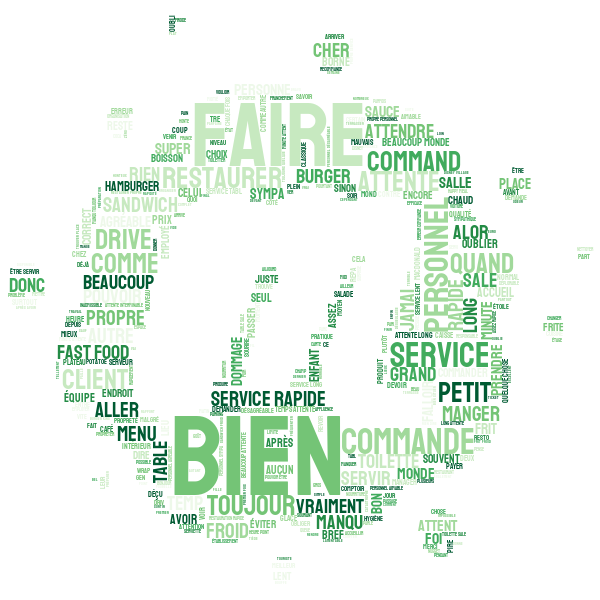

In [37]:
D = mcdonald.review.apply(lambda x: " ".join(process(x,lemma=True, sp_words=True)))
D.to_csv('test.csv',index=False)
ppstorelogo = stylecloud.gen_stylecloud(
                          file_path='test.csv',
                          icon_name = "fab fa-meetup",
                          size = 600,
                          palette='colorbrewer.sequential.Greens_7',
                          background_color ='white',
output_name='stylecloud_tw1.png')
Image(filename='stylecloud_tw1.png')
#counter_burger, plt2 = create_wordcloud(burgerking, lemma= True, sp_words=True,  figsize=(14,14));

<h3> BurgerKing</h3>

/home/zied/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


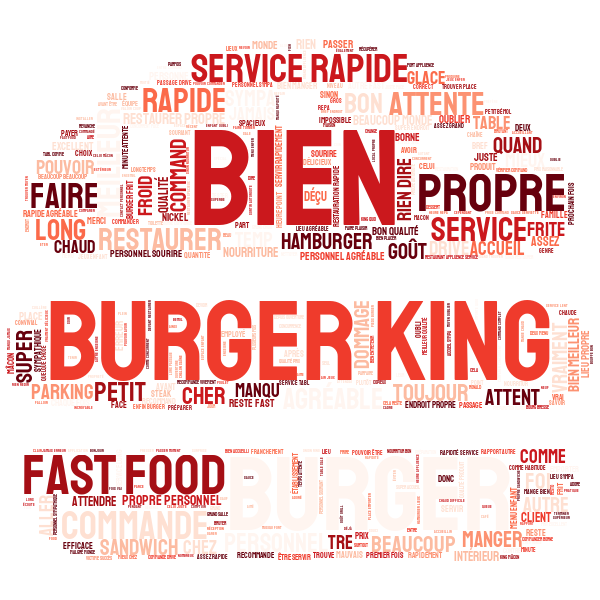

In [27]:
D = burgerking.review.apply(lambda x: " ".join(process(x,lemma=True, sp_words=True)))
D.to_csv('test.csv',index=False)
ppstorelogo = stylecloud.gen_stylecloud(
                          file_path='test.csv',
                          icon_name = "fas fa-hamburger",
                          size = 600,
                          palette='colorbrewer.sequential.Reds_9',
                          background_color ='white',
output_name='stylecloud_tw1.png')
Image(filename='stylecloud_tw1.png')
#counter_burger, plt2 = create_wordcloud(burgerking, lemma= True, sp_words=True,  figsize=(14,14));

<h3> Le Zinc </h3>

/home/zied/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/home/zied/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


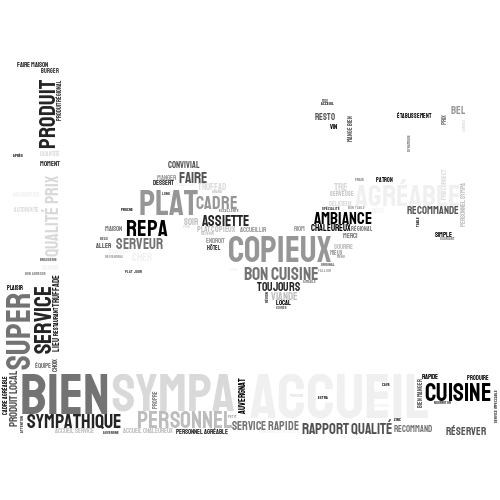

In [29]:
D = zinc.review.apply(lambda x: " ".join(process(x,lemma=True, sp_words=True)))
D.to_csv('test.csv',index=False)
D.to_csv('test.csv',index=False)
ppstorelogo = stylecloud.gen_stylecloud(
                          file_path='test.csv',
                          icon_name = "fas fa-chart-line",
                          size = 500,
                          palette='colorbrewer.sequential.Greys_9',
                          background_color ='white',
output_name='stylecloud_tw2.png')
Image(filename='stylecloud_tw2.png') 
#counter_zinc, plt3 = create_wordcloud(zinc, lemma= True, sp_words=True, figsize=(14,14));

- Ces Word clouds nous permettent  d'extraire les termes avec le maximum d'occurence. 
- En comparant les différents termes ( et surtout celles qui reflétent un opinion ) , on peut interpréter que Mac Do a une e-reputation neutre  vu la présence équilibré des termes qui représentent des opinions positifs ( Bien , propore , Sympa , Service Rapide )  avec celles négatifs (Attendre , manque , Sale , Dommage etc .. ) .
- Par rapport aux concurents, on trouve qu'il y a plus d'avis positifs surtout par rapport aux termes mentionnés ( Propre , Service Rapide , Bien , Sympa , Ambiance etc .. ) par rapport aux termes négatifs ( qui sont faibles chez Zinc et Burger King ) 

<h2><span style="color: green;">3 :Analyse de l'opinion: explicative / Opinion Analyst: Static Explanation  </span><h2>

- On se focalise sur les avis de Mac Do en le séparant selon les ratings 

In [31]:
pos_mcdonald = mcdonald[mcdonald.rating >3 ]
neg_mcdonald = mcdonald[mcdonald.rating <3 ]

pos_burger = burgerking[burgerking.rating >3 ]
neg_burger = burgerking[burgerking.rating <3 ]

pos_zinc = zinc[zinc.rating >3 ]
neg_zinc = zinc[zinc.rating <3 ]

<h3>Review positive et negative DU Macdonald</h3>


In [33]:
F = neg_mcdonald.review.apply(lambda x: " ".join(process(x,lemma=True, sp_words=True)))
p = pos_mcdonald.review.apply(lambda x: " ".join(process(x,lemma=True, sp_words=True)))

/home/zied/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


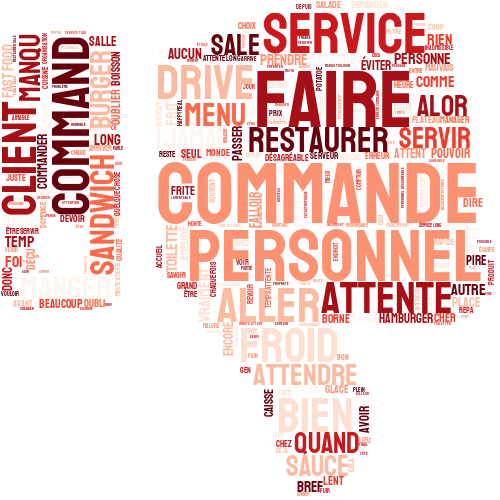

In [34]:
F.to_csv('test.csv',index=False)

ppstorelogo = stylecloud.gen_stylecloud(
                          file_path='test.csv',
                          icon_name = "fas fa-thumbs-down",
                          size = 500,
                          palette='colorbrewer.sequential.Reds_9',
                          background_color ='white',
output_name='stylecloud_tw3.png')
from IPython.display import Image
Image(filename='stylecloud_tw3.png') 

- Ici , on se focalise sur les opinions négatifs afin d'extraire les termes dont il y un mécontement de la communauté de Mac Do tels que Commande , Personnel , Servir , Attente , Froid etc .. 
- Donc,  les termes mentionnés  sont les axes que Mac Do doit réagir afin de fixer l'e-rputation chez ses clients.

/home/zied/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


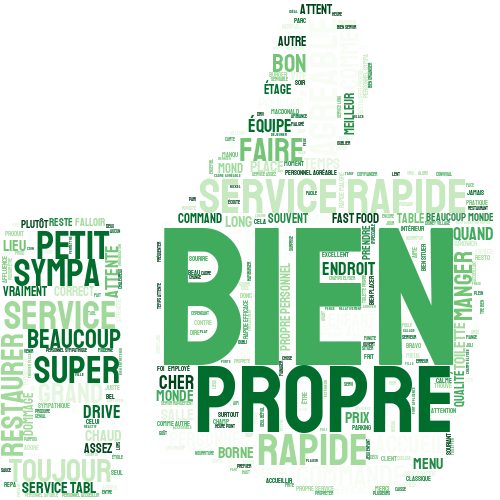

In [35]:
p.to_csv('test.csv',index=False)

ppstorelogo = stylecloud.gen_stylecloud(
                          file_path='test.csv',
                          icon_name = "fas fa-thumbs-up",
                          size = 500,
                          palette='colorbrewer.sequential.Greens_9',
                          background_color ='white',
output_name='stylecloud_tw3.png')
from IPython.display import Image
Image(filename='stylecloud_tw3.png') 

- Ici , on se focalise sur les opinions positifs afin d'extraire les termes dont il y un satisfaction de la communauté de Mac Do tels que Propre , Rapide , Endroit , Service table , équipe etc .. 
- Donc,  les termes mentionnés  sont les axes que Mac Do doit garder et les encourager afin de garder la bonne e-rputation chez cette partie de  clients.

<h3>Review positive et negative pos_burger</h3>

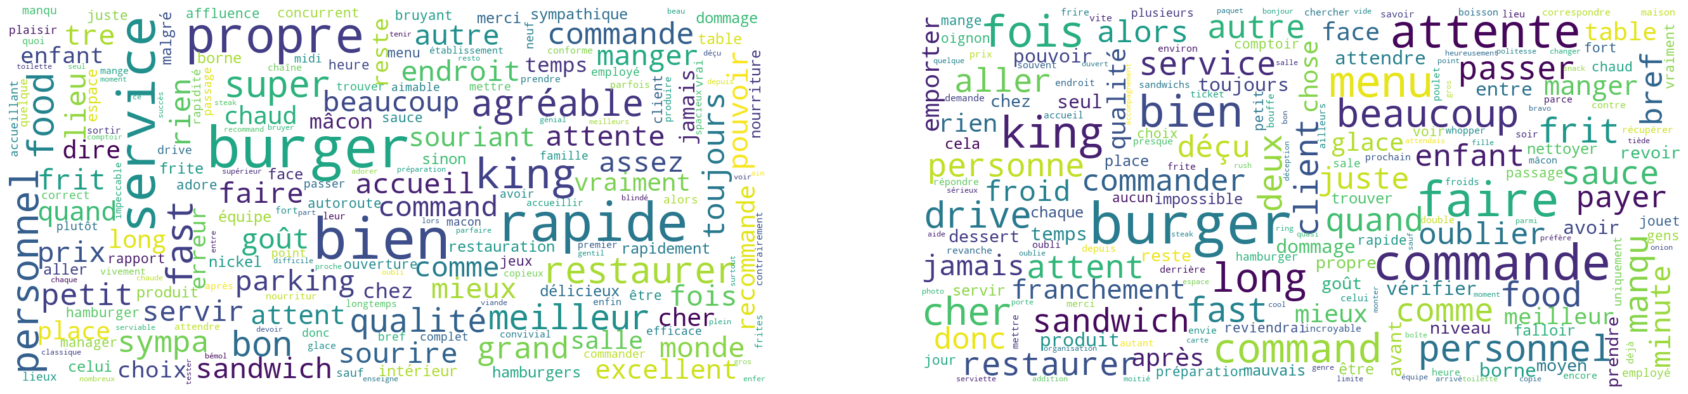

In [38]:
plt.figure(figsize=(30,30))

plot1 = plt.subplot(1,2,1)
plot2 = plt.subplot(1,2,2)

create_wordcloud_plot(pos_burger, plot1,lemma= True, sp_words=True);
create_wordcloud_plot(neg_burger, plot2,lemma= True, sp_words=True);

<h3>Review positive et negative Le zinc</h3>

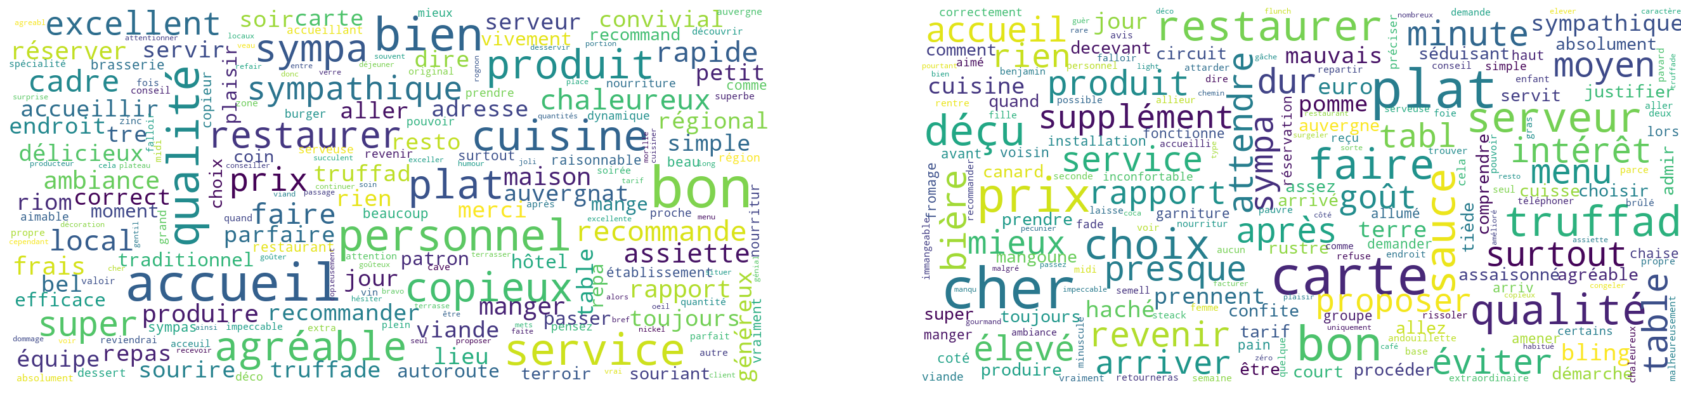

In [39]:
plt.figure(figsize=(30,30))

plot1 = plt.subplot(1,2,1)
plot2 = plt.subplot(1,2,2)

create_wordcloud_plot(pos_zinc, plot1,lemma= True, sp_words=True);
create_wordcloud_plot(neg_zinc, plot2,lemma= True, sp_words=True);

- D'aprés ces analyses de concurents , on peut extraire les points forts chez eux afin de bénificier ces bonnes e-reputations tels que prix , plat , carte , supplément , commande etc .. 
- En effet , on encourage Mac Do de travailler sur ces différents axes afin de gagner les clients de ses concurents directs.

<h2><span style="color: green;">4 :Analyse de l'opinion: prédictive / Opinion Analyst: Prediction  </span><h2>

- Dans la derniére partie , on a essayé d'interpréter les ratings selon les reviews mentionnés avec la méthodologie d'Analyse Sentimentale Pretrained model et les comaprer avec les ratings mentionnés afin de détecter s'il y a des communautés qui veulent un dommage de l'e-reputation de Mac Do France.

In [40]:
dictionnaire, texts = create_dictionnaire(mcdonald, lemma=True, sp_words=True)
tfidf, bag_words = create_model(dictionnaire, texts)

In [41]:
sentiments = mcdonald.review.apply(lambda x : TextBlob(x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0]) 
sentiments.name = "sentiment"
mcdonald_sent = pd.concat([mcdonald,sentiments],axis=1)

In [42]:
mcdonald_sent.head(3)

,review,rating,date,loc,sentiment
0,"Musique à fonds dans le fast-food, on ne s’ent...",2,2019-04-22,"Centre commercial Coty, Avenue René Coty, 7660...",-0.24625
1,"un endroit très accueillant, malgré qu’ils soi...",5,2020-03-22,"Centre commercial Coty, Avenue René Coty, 7660...",0.60750
2,Salade Caesar bonne mais assez gourmande par r...,3,2020-03-22,"Centre commercial Coty, Avenue René Coty, 7660...",0.31000


In [43]:
pos_sent = mcdonald_sent[mcdonald_sent.sentiment >= 0.8]
neg_sent = mcdonald_sent[mcdonald_sent.sentiment <= -0.8]
neutre_sent = mcdonald_sent[(mcdonald_sent.sentiment <= 0.2 ) & (mcdonald_sent.sentiment >= -0.2)]

<h3>Top positive Review du macdonald </h3>

In [44]:
pos_sent.sample(5)

,review,rating,date,loc,sentiment
5157,Mc do très correct ds l ensemble,4,2017-04-22,"Lieu dit Aux Poses Shopping, 74100 Etrembières...",0.800
4173,Employés très sympathiques.,5,2019-04-22,"Centre commercial Coty, Avenue René Coty, 7660...",1.000
3629,Une devanture sur le champs Élysées. Superbe v...,5,2018-04-22,"140 Av. des Champs-Élysées, 75008 Paris, France",1.000
809,"C'est génial, et très bon",5,2019-06-22,ZAC dit du Parc et du Centre Touristique Lieu ...,0.950
1666,Équipe réactive bon accueil mais propreté à re...,3,2019-08-22,"450 Traverse d'Orange, 84110 Saint-Romain-en-V...",0.875


<h3>Top negative Review du macdonald </h3>

In [45]:
neg_sent.sample(5)

,review,rating,date,loc,sentiment
6286,Des toilettes infâme et un service très long,1,2019-04-22,"Centre Commercial les 3 Fontaines, Avenue Pier...",-0.8
6830,40 mis d attente . Aïe c est très long 😥🤨,2,2019-04-22,"Espace Mendes France, Avenue de Paris, 79000 N...",-0.8
714,Très mauvaise gestion des clients.\nLe service...,1,2019-04-22,ZAC dit du Parc et du Centre Touristique Lieu ...,-1.0
2698,Vraiment très long pour être servi,3,2019-04-22,"ZAC du Cornillon Sud, 1 Rue des Trémies, 93200...",-0.8
6779,L attente et très longue,3,2019-08-22,"Espace Mendes France, Avenue de Paris, 79000 N...",-0.8


<h3>Top neutre Review du macdonald </h3>

In [47]:
neutre_sent.sample(5)

,review,rating,date,loc,sentiment
6744,"Attente interminable pour un drive , clairemen...",1,2019-04-22,"Espace Mendes France, Avenue de Paris, 79000 N...",-0.043333
2081,trompée de commande il ne s en sont même pas a...,2,2019-04-22,"450 Traverse d'Orange, 84110 Saint-Romain-en-V...",0.000000
6102,Pain des burgers secs tromper dans le dessert ...,3,2019-04-22,"Centre Commercial les 3 Fontaines, Avenue Pier...",-0.200000
5767,"Franchement, ça vaut pas burger king...",2,2019-08-22,"Centre Commercial les 3 Fontaines, Avenue Pier...",0.000000
5357,Multitudes de commandes passées sur UberEat. S...,1,2019-04-22,"37 Avenue Georges Clemenceau, 93420 Villepinte...",0.004000


<h1> Analyse Sentimentale Pretrained model (burgerking): </h1>

In [48]:
dictionnaire2, texts2 = create_dictionnaire(burgerking, lemma=True, sp_words=True)
tfidf2, bag_words2 = create_model(dictionnaire2, texts2)

In [49]:
sentiments = burgerking.review.apply(lambda x : TextBlob(x, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment[0]) 
sentiments.name = "sentiment"
burgerking_sent = pd.concat([burgerking,sentiments],axis=1)

In [50]:
burgerking_sent.sample(5)

,review,rating,date,sentiment
150,"Double steackhouse très loin de la photo, dégu...",1,2019-08-26,-0.012778
204,"Sympa service rapide personnel disponible,autr...",4,2019-06-26,0.150000
827,Pour ma part à long chiken à évité..,3,2019-10-26,-0.400000
1560,Nul pas mes glaces dans ma commande à emporter...,1,2019-04-26,-0.316667
122,Bien mais le service est vraiment long aux heu...,3,2019-08-26,-0.400000


In [51]:
pos_sent = burgerking_sent[burgerking_sent.sentiment >= 0.8]
neg_sent = burgerking_sent[burgerking_sent.sentiment <= -0.8]
neutre_sent = burgerking_sent[(burgerking_sent.sentiment <= 0.2 ) & (burgerking_sent.sentiment >= -0.2)]

In [52]:
pos_sent.sample(5)

,review,rating,date,sentiment
394,Très agréable acceuille,5,2019-04-26,1.0
912,"Vraiment bon, burger avec un goût de grill ça ...",4,2019-04-26,1.0
1250,Personel très agréable,5,2019-04-26,1.0
213,Très bon mieux que McDo,5,2019-06-26,1.0
1655,Très bon comme toujours,5,2019-04-26,1.0


In [53]:
neg_sent.sample(5)

,review,rating,date,sentiment
897,Le passage au drive et exceptionnellement long...,2,2019-08-26,-0.976562
1188,Attente très longue pour 3 places et 2 café s...,1,2019-04-26,-0.800000
1825,Attente très longue pour 3 places et 2 café s...,1,2019-04-26,-0.800000
1449,"Déçu Burger king , à supprimer son offre un bu...",1,2019-08-26,-1.000000
211,note baisser car manque es steak dans les menu...,3,2019-11-26,-1.000000


In [54]:
neutre_sent.sample(5)

,review,rating,date,sentiment
350,"Quand c’est le rush, si vous souhaitez prendre...",3,2019-08-26,-0.032500
1184,Très bien! bien que légèrement gras,5,2019-04-26,-0.116667
1797,"Nous avons été servis en à peine une minute, d...",5,2019-04-26,0.000000
1824,"Bonjour \nJe sors du burger king à l'instant, ...",4,2018-04-26,0.197500
924,Etablissement propre et bien tenu. Pas trop d'...,4,2019-04-26,0.127500


<h1> Sentiment analysis using Tweeter dataset </h1>

In [55]:
rating_map = {1:0,2:0,3:0,4:1,5:1}
df_burgerking_train = pd.concat([burgerking , pd.Series(burgerking.rating.apply(lambda x: rating_map[x]), name="target", index= burgerking.index)], axis=1)
df_burgerking_train.head()

,review,rating,date,target
0,C'est un bon burger King il n'y a rien à dire ...,4,2020-03-26,1
1,Commande à emporter. Heureusement que nous vér...,2,2020-03-26,0
2,Un peu déçu... Pour le prix je m'attendais à m...,2,2020-03-26,0
3,Burger King bien organisé et personnel plutôt ...,4,2019-12-26,1
4,Un peu bruyant mais en même temps il était bli...,5,2019-04-26,1


In [56]:
text_preprocessed = df_burgerking_train.review.apply(lambda x: process(x, lemma=False, sp_words=True))
df_burgerking_train = pd.concat([df_burgerking_train, pd.Series(text_preprocessed, name="review_treated", index=df_burgerking_train.index)],axis=1)

In [58]:
bagofword = CountVectorizer()

In [59]:
bag = bagofword.fit_transform(text_preprocessed.apply(lambda x: " ".join(x)).values)

In [60]:
tfidf = TfidfTransformer()

In [61]:
tfidf_matrix = tfidf.fit_transform(bag).toarray()

In [62]:
tfidf_matrix.shape

(1911, 1300)

In [63]:
model = keras.models.Sequential([
    keras.layers.Dense(1024, input_shape=(tfidf_matrix.shape[1],), activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,  activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation="sigmoid")
])

In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              1332224   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 2,382,849
Trainable params: 2,382,849
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.compile("adam",keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [66]:
X_train, X_test, y_train, y_test = train_test_split(df_burgerking_train.review_treated, df_burgerking_train.target)
X_train_treated = tfidf.transform(bagofword.transform(X_train.apply(lambda x: " ".join(x)))).toarray()
X_test_treated = tfidf.transform(bagofword.transform(X_test.apply(lambda x: " ".join(x)))).toarray()

In [67]:
history = model.fit(X_train_treated, y_train, epochs=50, batch_size=128, validation_data=(X_test_treated,y_test), callbacks=[EarlyStopping(patience=3)])


Train on 1433 samples, validate on 478 samples
Epoch 1/50
1433/1433 [==============================] - 0s 333us/step - loss: 0.6289 - accuracy: 0.6727 - val_loss: 0.6068 - val_accuracy: 0.6820
Epoch 2/50
1433/1433 [==============================] - 0s 232us/step - loss: 0.5824 - accuracy: 0.7585 - val_loss: 0.5419 - val_accuracy: 0.8870
Epoch 3/50
1433/1433 [==============================] - 0s 232us/step - loss: 0.4984 - accuracy: 0.9442 - val_loss: 0.4846 - val_accuracy: 0.9226
Epoch 4/50
1433/1433 [==============================] - 0s 237us/step - loss: 0.4589 - accuracy: 0.9693 - val_loss: 0.4647 - val_accuracy: 0.9477
Epoch 5/50
1433/1433 [==============================] - 0s 245us/step - loss: 0.4483 - accuracy: 0.9826 - val_loss: 0.4564 - val_accuracy: 0.9540
Epoch 6/50
1433/1433 [==============================] - 0s 233us/step - loss: 0.4446 - accuracy: 0.9881 - val_loss: 0.4496 - val_accuracy: 0.9665
Epoch 7/50
1433/1433 [==============================] - 0s 248us/step - loss

In [69]:
naive = GaussianNB()
naive.fit(X_train_treated,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [70]:
accuracy_score(naive.predict(X_test_treated),y_test)

0.9330543933054394

In [71]:
test = tfidf.transform(bagofword.transform(mcdonald.review.apply(lambda x: process(x, lemma=False, sp_words=True)).apply(lambda x: " ".join(x)))).toarray()

In [72]:
results_naive = pd.Series(naive.predict(test), name="prediction", index=mcdonald.index)
results_deep = pd.Series(np.round(model.predict(test).ravel()), name="prediction", index=mcdonald.index)

In [73]:
naive_df = pd.concat([mcdonald, results_naive] , axis=1)
deep_df = pd.concat([mcdonald, results_deep] , axis=1)

In [79]:
naive_df.sample(10)

,review,rating,date,loc,prediction
6247,Le seul bémol c'est :pas de caisses public.uti...,3,2016-04-22,"Centre Commercial les 3 Fontaines, Avenue Pier...",1
4229,J'ai été légèrement déçue par ce Mcdo qui est ...,4,2019-04-22,"Gare SNCF Chateaucreux, 2 Espl. de France, 420...",1
396,Sur plusieurs commandes de McFleurie j’ai trou...,3,2019-09-22,ZAC dit du Parc et du Centre Touristique Lieu ...,1
6156,J'ai attendu 45 min mon menu ne recommande pas,1,2019-04-22,"Centre Commercial les 3 Fontaines, Avenue Pier...",1
2211,Commande très longue à arriver aoors que le re...,3,2019-04-22,"450 Traverse d'Orange, 84110 Saint-Romain-en-V...",0
8,"Un McDo comme partout ailleurs, classique mais...",4,2020-02-22,"Centre commercial Coty, Avenue René Coty, 7660...",0
6189,Je commence par l entrée du Resto ou bien sur ...,1,2017-04-22,"Centre Commercial les 3 Fontaines, Avenue Pier...",0
3171,equipe chaleureux et dynamique on reviendra,5,2019-07-22,"140 Av. des Champs-Élysées, 75008 Paris, France",1
2288,On connais tout le monde c'est chiant on peut ...,3,2018-04-22,"450 Traverse d'Orange, 84110 Saint-Romain-en-V...",0
830,Blindé de monde pas assez de place et long,1,2019-04-22,ZAC dit du Parc et du Centre Touristique Lieu ...,1


In [80]:
deep_df.sample(10)

,review,rating,date,loc,prediction
3700,une grande plage ouverture propre et personnel...,5,2018-04-22,"140 Av. des Champs-Élysées, 75008 Paris, France",1.0
1534,Nous sommes arrivés dans un mac do quasi vide ...,1,2019-04-22,"Centre Commercial Auchan, Rue Anatole France, ...",0.0
6738,4 borne qui ne marche pas trop attente,1,2019-07-22,"Espace Mendes France, Avenue de Paris, 79000 N...",0.0
1220,Lieu toujours agréable pour les petits et les ...,4,2018-04-22,ZAC dit du Parc et du Centre Touristique Lieu ...,1.0
1636,J'aime pas mac do. Trop pour les gros. Et que ...,1,2019-09-22,"450 Traverse d'Orange, 84110 Saint-Romain-en-V...",1.0
770,"Ce restaurant Mc Donald's Disney village, les ...",4,2019-04-22,ZAC dit du Parc et du Centre Touristique Lieu ...,1.0
1697,C'est le macdo le plus nul que je connaisse. \...,1,2019-04-22,"450 Traverse d'Orange, 84110 Saint-Romain-en-V...",0.0
6030,Mcdo basique. Sans plus,3,2019-04-22,"Centre Commercial les 3 Fontaines, Avenue Pier...",0.0
5420,Personnel pas super agréable...,3,2019-04-22,"37 Avenue Georges Clemenceau, 93420 Villepinte...",1.0
516,Trop d'attente. Personnel peu aimable et lent...,2,2019-04-22,ZAC dit du Parc et du Centre Touristique Lieu ...,0.0


In [81]:
pos_reviews = deep_df[deep_df.prediction==1].groupby('rating').count()['prediction']
pos_reviews

rating
1    615
2    350
3    652
4    855
5    782
Name: prediction, dtype: int64

In [82]:
neg_reviews = deep_df[deep_df.prediction==0].groupby('rating').count()['prediction']
neg_reviews

rating
1    1774
2     732
3     706
4     374
5     201
Name: prediction, dtype: int64

In [83]:
pos_reviews_naive = naive_df[naive_df.prediction==1].groupby('rating').count()['prediction']
pos_reviews_naive

rating
1    877
2    505
3    867
4    903
5    786
Name: prediction, dtype: int64

In [84]:
neg_reviews_naive = naive_df[naive_df.prediction==0].groupby('rating').count()['prediction']
neg_reviews_naive

rating
1    1512
2     577
3     491
4     326
5     197
Name: prediction, dtype: int64

- Aprés la comparaison des ratings prédits par note modéle qui est déja entrainé , on trouve que les resultats sont presque égale à ceux mentionnés par les clients. Donc , on peut interpréter qu'il n y a pas vraiment une communauté qui essaye d'endomager l'e-reputation de mac Do.

## Conclusion : 

- En se basant sur les resultats obtenus des différents méthodologies , on peut conclure que l'e-reputation de Mac Do France est moyenne.En effet , il y a un équilibre entre les opinions positifs et négatifs . 
- On a essayé d'extraire les points forts et les points faible de Mac Do afin d'encourager de garder les points forts et réagire par rapport aux points faibles qui sont mentionnés dans les opinions négatifs surtout en se basant sur les armes de ses concurents afin de gagner plus de clients et d'élargir sa communauté.
- De plus , on a constaté qu'il n y pas des personnes qui essayent de détruire l'e-reputation de Mac Do France ou qui essaye de faire un bad Buzz mais plutot des opinions qui sont conformes avec les avis mentionnés.



- Based on the results obtained from the different methodologies, we can conclude that the e-reputation of MacDo France is medium, as there is a balance between positive and negative opinions. 
- We have been trying to extract the strengths and weaknesses of MacDo in order to encourage them to keep the strong points and react to the weaknesses that are mentioned in the negative opinions, especially based on the weapons of its competitors in order to gain more customers and expand its community.
- Furthermore, we have noticed that there are no people who try to destroy the e-Reputation of MacDo France or who try to make a bad Buzz but instead opinions that are in line with the mentioned opinions.
